# pyControl - pyPhotometry data synchronisation example

This notebook shows how to synchronise [pyControl](https://pycontrol.readthedocs.io) behavioural data with [pyPhotometry](https://pyphotometry.readthedocs.io) recordings using pyControl's rsync [synchronisation](https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation/) tool.

The data are calcium signals recorded from dopamine neuron terminals in nucleus accumbens in a task where rewards became available in a nose-poke on a random interval schedule. See [Akam & Walton 2019](https://rdcu.be/bpvvJ) for details.

Import the standard python modules needed for the analysis.

In [1]:
import os
import numpy as  np
import pylab as plt

Import the pyControl data import and synchronisation modules (found in the pyControl [tools](https://bitbucket.org/takam/pycontrol/src/default/tools/) folder), and the pyPhotometry data import module (found in the pyPhotometry [tools](https://bitbucket.org/takam/pyphotometry/src/default/tools/) folder).  The pyControl and pyPhotometry `data_import.py` module files have been renamed `pyControl_import.py` and `pyPhotometry_import.py` to avoid a name collision.

In [2]:
from pyControl_import import Session
from pyPhotometry_import import import_ppd
from rsync import Rsync_aligner

Import the data files.

In [3]:
data_folder = 'data' # Here the data folder is a relative path but an absolute path can also be used.

behaviour_filepath  = os.path.join(data_folder, 'P14-NAc-L-2018-11-29-143413.txt')
photometry_filepath = os.path.join(data_folder, 'P14-NAc-L-2018-11-29-143403.ppd')

behaviour_session = Session(behaviour_filepath)
photometry_data = import_ppd(photometry_filepath)

print(f"Photometry sampling rate: {photometry_data['sampling_rate']}Hz")

Importing data file: P14-NAc-L-2018-11-29-143413.txt
Photometry sampling rate: 130Hz


Get the pyControl times and pyPhotometry sample numbers where the sync pulses occured.

In [4]:
pulse_times_beh = behaviour_session.times['rsync'] # Sync pulse times recorded by pyControl.

pulse_samples = 1+np.where(np.diff(photometry_data['digital_2']) == 1)[0] # Photometry samples when sync pulse occured.

Setup an `Rsync_aligner` object to convert behavioural event times recorded by pyControl to photometry signal sample numbers. 

The pyControl pulse times are in units of ms whereas each sample of the photometry data corresponds to 7.69ms as the sampling rate is 130Hz.  To work out which pulses correspond to which in the two sequences, the alignment code needs to know their relative units.  We can either specify this manually by specifying the units of each pulse sequence in ms using the `units_A` and `units_B` arguments, or the alignment code can estimate the relative units automatically from the pulse sequences themselves by setting the units arguments to `'auto'`.  Using automatic estimation is more convinient but will not work if you have too few sync pulses to accurately estimate the mean inter-pulse interval.  Specifying the units manually can also be a good sanity check to make sure the data are as expected.

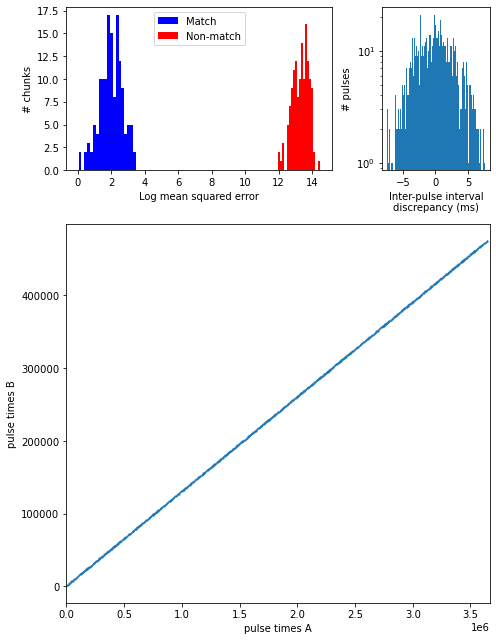

In [5]:
# Instantiate aligner object specifying the units for each pulse sequence manually in ms.
aligner = Rsync_aligner(pulse_times_A=pulse_times_beh, pulse_times_B=pulse_samples,
                        units_A=1, units_B=1000/photometry_data['sampling_rate'], plot=True)

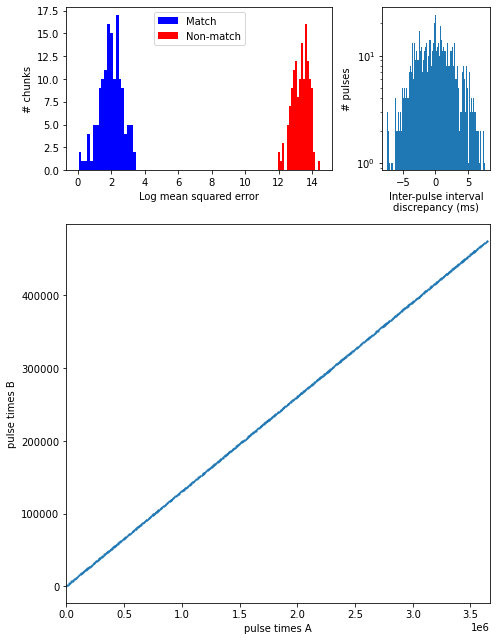

In [6]:
# Instantiate aligner object using automatic estimation of the relative units for the two pulse sequences.
aligner = Rsync_aligner(pulse_times_A=pulse_times_beh, pulse_times_B=pulse_samples,
                        units_A='auto', units_B='auto', plot=True)

The above plots are generated if you set the `plot` argument to true when you instantiate the `Rsync_aligner`.  If the alignment code has found a match between the pulse sequences, there will be a clear seperation between the *match* and *non-match* distributions in the top left panel.  The top right panel shows the discrepancy between matching inter pulse intervals recorded on the two systems, the range is as expected given the ~7ms duration between photometry samples.  The bottom panel shows the correspondence between pulse times recorded on each system.

Extract photometry traces around rewards.

In [7]:
n = 50                     # number of reward to average.
window_ms = [-1000, 4000]  # time window around reward to plot in ms.

window_samples = (np.array(window_ms)*photometry_data['sampling_rate']/1000).astype(int) # time window around reward in samples.

reward_times = behaviour_session.times['reward'][:n] # Times when first n rewards occured.

reward_samples = aligner.A_to_B(reward_times).astype(int) # Convert reward times to photometry sample numbers.

reward_traces = np.vstack([
    photometry_data['analog_1_filt'][rs+window_samples[0]:rs+window_samples[1]] for rs in reward_samples]) 

Plot average calcium signal around reward with standard error shown as shaded area.

Text(0, 0.5, 'GCaMP signal (V)')

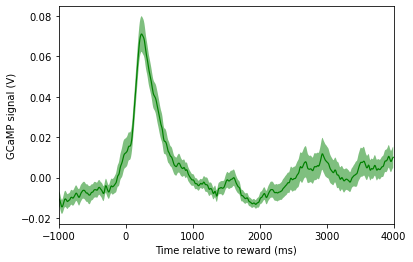

In [8]:
mean_trace = np.mean(reward_traces,0)                                # Average reward response
trace_sem  = np.std(reward_traces,0)/np.sqrt(reward_traces.shape[0]) # Reward response standard error.

rel_time = np.arange(*window_samples) * 1000/photometry_data['sampling_rate'] # Time relative to reward.

plt.fill_between(rel_time, mean_trace-trace_sem, mean_trace+trace_sem, facecolor='g', alpha=0.5)
plt.plot(rel_time, mean_trace, 'g', linewidth=1.2)
plt.xlim(*window_ms)
plt.xlabel('Time relative to reward (ms)')    
plt.ylabel('GCaMP signal (V)')